# Assignment — Generative Network Models

In [3]:
from scipy.stats import ks_2samp
import random
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math
from scipy.stats import kstest 
import itertools

### Task 1. Watts-Strogatz model (2 points)

Implement Watts-Strogatz model (small-world model) — rewire an edge with probability `p` in a ring lattice with `n` nodes and `k` degree.

In [4]:
def watts_strogatz_graph(n, k, p):
    G = ring_lattice(n, k)
    for node in G.nodes:
        rewire(G, node, k, p)
    return G

Write a function `ring_lattice` that returns a regular ring lattice with `n` nodes (0, 1, 2, ..., n-1) and `k` node degree. In a case of an odd node degree, it round it to the nearest smaller even number.

In [5]:
def adjacent_edges(nodes, halfk): 
    n = len(nodes) 
    for i, u in enumerate(nodes): 
        for j in range(i+1, i+halfk+1): 
            v = nodes[j % n] 
            yield u, v

In [6]:
def ring_lattice(n, k):
    # YOUR CODE HERE
    if k%2 == 1:
      k = k-1
    G = nx.Graph() 
    nodes = range(n) 
    G.add_nodes_from(nodes) 
    G.add_edges_from(adjacent_edges(nodes, k//2)) 
    return G
    #raise NotImplementedError()

In [7]:
assert nx.degree_histogram(ring_lattice(10, 2))[2] == 10
assert nx.degree_histogram(ring_lattice(10, 3))[2] == 10
assert nx.degree_histogram(ring_lattice(10, 4))[4] == 10

Write a function `rewire` that takes in input a ring lattice `G`, a `node`, a model parameter `k` and probability `p`. For every right hand side neighbor $i$, the function rewires an edge (`node`, $i$) into a random edge (`node`, $j$) with probability `p` where $i \neq j \neq $ `node`.

*Hints:*
* *Why do we only rewire right hand side edges? We want to guarantee that only untouched in previous iterations edges will be rewound. Look at the picture — we could not move the red edges in previous iterations.
![](https://raw.githubusercontent.com/netspractice/network-science/main/images/watts_strogatz_how_to_rewire.png)*
* *To speed up the generation, do not filter nodes to random selection. If a selected node produces an existing edge or a loop, just skip it.*

In [8]:
def rewire(G, node, k, p):
    # YOUR CODE HERE
    nodes = set(G) 
    for u, v in G.edges():
      if u == node:
        if np.random.random() < p: 
          choices = nodes - {u} - set(G[u]) 
          new_v = np.random.choice(list(choices)) 
          G.remove_edge(u, v)
          if (u,new_v) not in G.edges():
            G.add_edge(u, new_v)
    #raise NotImplementedError()

In [9]:
cases = [[50, 8, 0.1], 
         [1000, 10, 0.01],
         [1000, 10, 0.5],
         [1000, 10, 0.99]]
for n, k, p in cases:
    G = watts_strogatz_graph(n, k, p)
    assert nx.number_of_nodes(G) == n
    assert nx.number_of_edges(G) == int(k / 2 * n)
    degree_seq = [degree for (node, degree) in G.degree]
    nxG = nx.watts_strogatz_graph(n, k, p, 1)
    nxdegree_seq = [degree for (node, degree) in nxG.degree]
    assert ks_2samp(degree_seq, nxdegree_seq).pvalue > 0.05

Let us draw a small-world graph in some steps of the algorithm

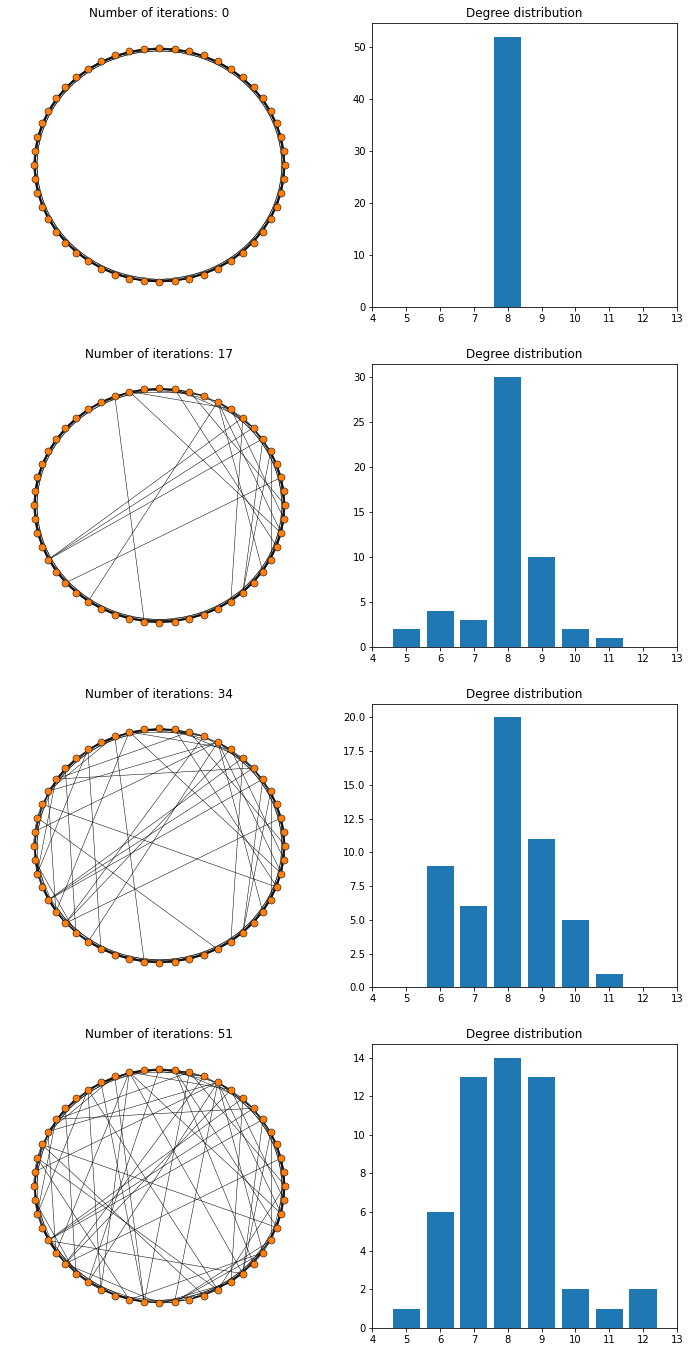

In [10]:
n, k, p = 52, 8, 0.2
G = ring_lattice(n, k)
plt.figure(figsize=(12, 6 * 4))
i = 1
for node in G.nodes:
    if node in np.arange(0, n+1, int(n/3)):
        plt.subplot(4, 2, i)
        plt.title('Number of iterations: {}'.format(node))
        nx.draw_circular(
            G,
            node_size=50, 
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            node_color='tab:orange')
        i += 1
        plt.subplot(4, 2, i)
        degree_seq = [degree for (node, degree) in G.degree]
        bins, freq = np.unique(degree_seq, return_counts=True)
        plt.bar(bins, freq)
        plt.xlim((4, 13))
        plt.title('Degree distribution')
        i += 1
    rewire(G, node, k, p)

### Task 2. Average path length in Watts-Strogatz (1 points)

Let us check that the average path length tends to theoretical value during building the small-world model.

$$\langle L \rangle = \begin{cases}
N/2k, \text{ if } p \to 0 \\
\log(N)/\log(k), \text{ if } p \to 1
\end{cases}$$

So that we have a lower and upper limits of path lengths for $0 < p < 1$.

Write a function `smallworld_path_len` with Watts-Strogatz model parameters `n, k, p` that returns np.array of average path lengths in each step (node). The length of the array is `n`.

*Hint: to calculate the average shortest path length, use `nx.average_shortest_path_length`*

In [11]:
def smallworld_path_len(n, k, p):
    # YOUR CODE HERE
    #G = watts_strogatz_graph(n, k, p)
    apl_Array = []
    G = ring_lattice(n, k)
    for node in G.nodes:
        rewire(G, node, k, p)
        apl_Array.append(nx.average_shortest_path_length(G))
    apl_Array = np.asarray(apl_Array)
    return apl_Array
    #raise NotImplementedError()

In [12]:
n, k, p = 101, 10, 0.05
lengths = smallworld_path_len(n, k, p)
step_space = np.log(np.arange(1, len(lengths) + 1))
X = np.stack([step_space, np.ones(lengths.shape[0])], axis=1)
assert lengths.shape[0] == n
assert 0.1 < -(np.linalg.pinv(X) @ np.log(lengths))[0] < 0.25

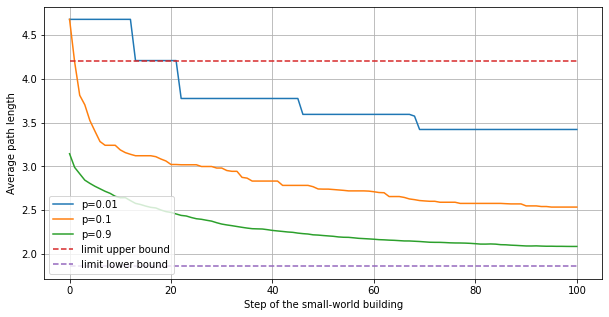

In [13]:
plt.figure(figsize=(10, 5))

n, k, p = 101, 12, 0.01
lengths = smallworld_path_len(n, k, p)
plt.plot(lengths, label=f'p={p}')

n, k, p = 101, 12, 0.1
lengths = smallworld_path_len(n, k, p)
plt.plot(lengths, label=f'p={p}')

n, k, p = 101, 12, 0.9
lengths = smallworld_path_len(n, k, p)
plt.plot(lengths, label=f'p={p}')

plt.xlabel('Step of the small-world building')
plt.ylabel('Average path length')
plt.grid()
plt.plot([0, 100], [n / 2 / k, n / 2 / k], '--', 
         label='limit upper bound')
plt.plot([0, 100], [np.log(n) / np.log(k), np.log(n) / np.log(k)], '--',
         label='limit lower bound')
plt.legend(loc='lower left')
plt.show()

### Task 3. Barabasi-Albert model (2 points)

Implement Barabasi-Albert model (preferential attachment model) – a growth process where each new node connects to `m` existing nodes. The higher node degree, the higher probability of the connection. The final number of nodes is `n`.

You start from a star graph with `m + 1` nodes. In each step you create `m` edges between a new node and existing nodes. The probability of connection to the node $i$ is 
$$p(i) = \frac{k_i}{\sum k}$$

Write a function `attach` that attaches a `node` to a graph `G` through `m` edges.

*Hint: Create a list with repeated nodes from a list of edges. For example, $[(1, 2), (2, 3), (2, 4)] \to [1, 2, 2, 3, 2, 4]$. Uniformly select nodes one-by-one. Apply `random.choice` instead of `np.random.choice` to speed up the generation.*

In [14]:
'''Do not touch the cell'''
def barabasi_albert_graph(n, m, random_seed=1):
    G = nx.star_graph(m)
    for i in range(1, n - m):
        attach(m + i, G, m)
    return G

In [15]:
def attach(node, G, m):
  #i = 0
  #while i<m:
    #nodes_probs = []
    #for node in G.nodes():
      #node_degr = G.degree(node)
      #node_proba = node_degr / (2 * len(G.edges()))
      #nodes_probs.append(node_proba)
    #random_proba_node = np.random.choice(G.nodes(),p=nodes_probs)
    #new_edge = (random_proba_node , node)
    #if new_edge  not in G.edges():
      #pass
    #else:
      #G.add_edge(random_proba_node , node)
    #i=i+1
  #repeated_nodes = list(itertools.chain(*G.edges))
  #repeated_nodes = [vertex for edge in G.edges for vertex in edge]
  repeated_nodes=[]
  for u , v in G.edges():
    repeated_nodes.append(u)
    repeated_nodes.append(v)
  i = 0 
  #repeated_nodes_arr = np.asarray(repeated_nodes)
  while i <m:
    #selected_node = random.choice(repeated_nodes_arr)
    selected_node = random.choice(repeated_nodes)
    new_edge = (selected_node , node)
    if new_edge in G.edges():
      pass
    else:
      G.add_edge(selected_node , node)
      i = i+1
    #G.add_edge(selected_node,node)
    #repeated_nodes_arr =repeated_nodes_arr[repeated_nodes_arr!= selected_node]
    #i=i+1
  return G
  # YOUR CODE HERE
    #raise NotImplementedError()

In [16]:
G = nx.star_graph(3)
attach(4, G, 3)
assert nx.number_of_edges(G) == 6

cases = [[10, 3], 
         [1000, 3], 
         [1000, 20]]
for n, m in cases:
    G = barabasi_albert_graph(n, m)
    degree_seq = [degree for (node, degree) in G.degree]
    nxG = nx.barabasi_albert_graph(n, m)
    nxdegree_seq = [degree for (node, degree) in nxG.degree]
    assert ks_2samp(degree_seq, nxdegree_seq).pvalue > 0.05

Let us see what the growth process looks like

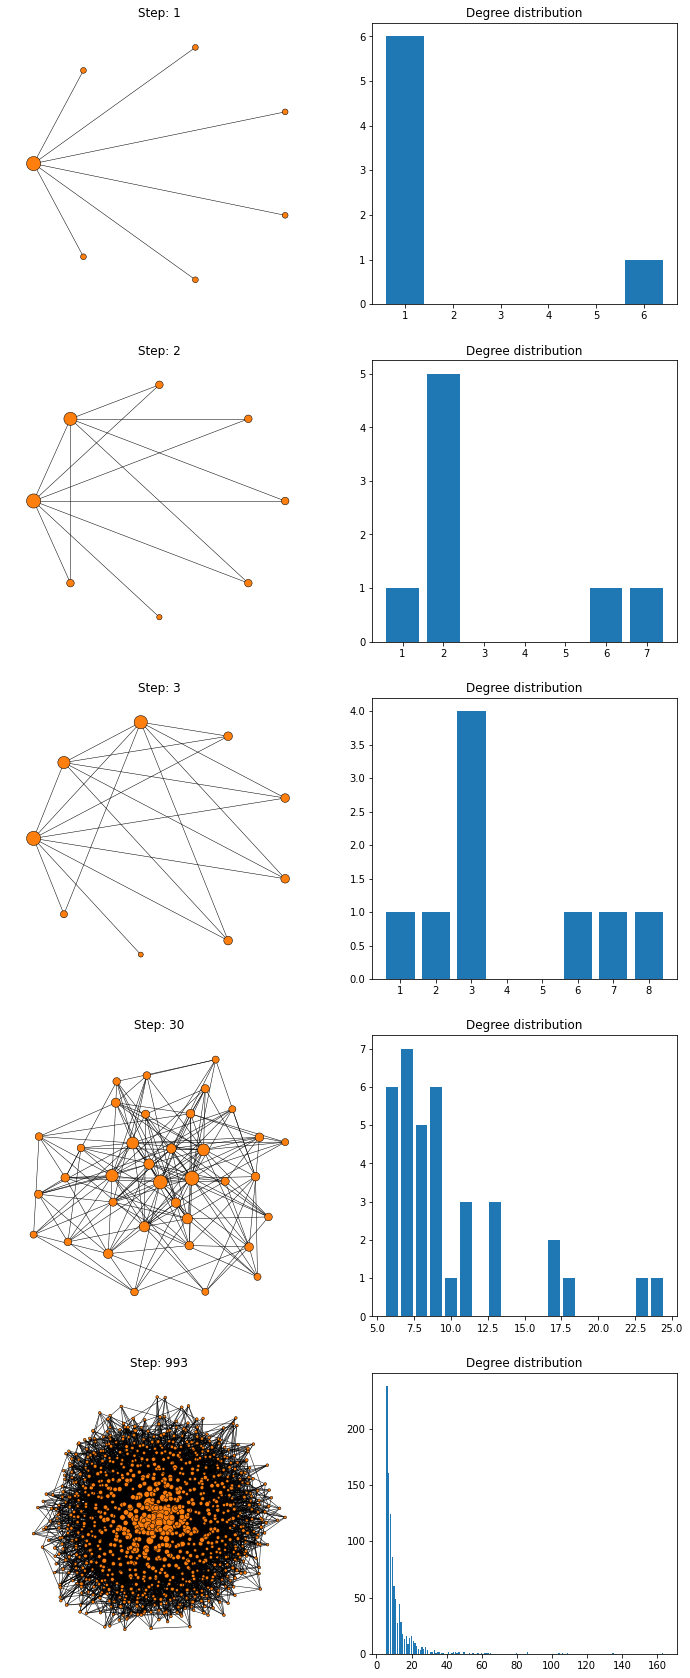

In [17]:
n, m = 1000, 6
G = nx.star_graph(m)
plt.figure(figsize=(12, 6 * 5))
j = 1
for i in range(1, n - m):
    if i in [1, 2, 3, 30, n-m-1]:
        plt.subplot(5, 2, j)
        j += 1
        sizes = np.array(list(nx.degree_centrality(G).values()))
        sizes = sizes / max(sizes) * 200
        if i <= 3:
            pos = nx.layout.shell_layout(G)
        else:
            pos = nx.layout.spring_layout(G)
        nx.draw(
            G,
            pos=pos,
            with_labels=False, 
            node_size=sizes, 
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            node_color='tab:orange')
        plt.title('Step: {}'.format(i))
        degree_seq = [degree for (node, degree) in G.degree]
        bins, freq = np.unique(degree_seq, return_counts=True)
        plt.subplot(5, 2, j)
        j += 1
        plt.bar(bins, freq)
        plt.title('Degree distribution')
    attach(m + i, G, m)

### Task 4. Degree distribution in Barabasi-Albert model (1 points)

Barabasi-Albert graph has a degree distribution of the form

$$P(k) = \frac{2m^2}{k^3}$$

That is Power law with $\alpha = 3$ and $k_\min = m$. 

Check this fact by an experiment — generate a set of Barabasi-Albert graphs and estimate parameters of Power law using MLE

$$\alpha = 1 + n \left[\sum_i \log \frac{k_i}{k_\min} \right]^{-1}$$

where the $k_\min$ is selected by minimal Kolmogorov-Smirnov distance between observed and theoretical distributions.

First, write a function `power_law_cdf` that takes an argument and parameters of the Power law distribution and returns the CDF.

In [18]:
def power_law_cdf(k, alpha=3.5, k_min=1):
    # YOUR CODE HERE
    C = (alpha - 1) / k_min ** (1 - alpha)
    return 1 + (C*k**(1-alpha)/(1-alpha))

In [19]:
assert power_law_cdf(2, 2, 1) == 0.5
assert power_law_cdf(10, 2, 1) == 0.9

Next, write a function `mle_power_law_params` that takes a degree sequence and returns a tuple: the best $\alpha$, the best $k_\min$ w.r.t. MLE

_Hint: use `scipy.stats.kstest` where a theoretical CDF is a `power_law_cdf` function and `args=(alpha, k_min)`_

In [20]:
def mle_power_law_params(degree_sequence):
  sum_of_log = 0 
  min_D = 1000
  k_min_hat= 0
  alpha_hat = 0 
  np.sort(degree_sequence)
  for k_min in degree_sequence:
    tmp_degree_sequence = degree_sequence[degree_sequence>k_min]
    if (tmp_degree_sequence.size >0):
      n = tmp_degree_sequence.size
      for k in tmp_degree_sequence:
        sum_of_log = sum_of_log + math.log(k/k_min)
      if (sum_of_log != 0):  
        alpha = 1+ (n/sum_of_log)
        statistics , pvalue = kstest(tmp_degree_sequence, cdf=power_law_cdf, args =(alpha, k_min))
        if (min_D> np.abs(statistics)):
          min_D= statistics
          k_min_hat = k_min
          alpha_hat= alpha
    sum_of_log = 0
  return alpha_hat,k_min_hat

In [21]:
assert mle_power_law_params(np.array([1, 2, 3]))[0] > 0
assert mle_power_law_params(np.array([1, 2, 3]))[1] > 0

Write a function `estimate_power_law` that generates Barabasi-Albert graphs with `n` nodes, from `m_min` to `m_max` connections and returns a tuple of np.arrays: $\alpha$ and $k_{\min}$ for each graph.

In [22]:
def estimate_power_law(n, m_min, m_max):
    i = m_min
    alpha_list = []
    k_min_list = []
    while (i>= m_min) and (i<=m_max):
      G = barabasi_albert_graph(n , i)
      degree_sequence = [d for n, d in G.degree()]
      alpha , k_min = mle_power_law_params(np.asarray(degree_sequence))
      alpha_list.append(alpha)
      k_min_list.append(k_min)
      i = i +1
    return np.asarray(alpha_list), np.asarray(k_min_list)

In [23]:
'''Check the Power law parameters'''
n, m_min, m_max = 500, 2, 20
alpha, k_min = estimate_power_law(n, m_min, m_max)
assert alpha.shape[0] == m_max - m_min + 1
assert 2 < alpha.mean() < 4
assert k_min[0] < k_min[-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


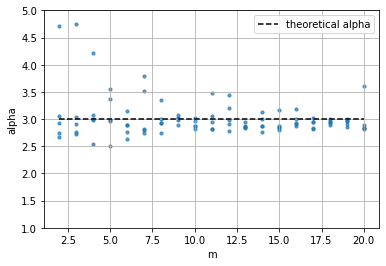

In [24]:
n, m_min, m_max = 500, 2, 20
m_space = np.arange(m_min, m_max + 1)
for _ in range(5):
    alpha, k_min = estimate_power_law(n, m_min, m_max)
    plt.scatter(m_space, alpha, alpha=0.7, c='tab:blue', s=10)
plt.plot([2, 20], [3, 3], 'k--', label='theoretical alpha')
plt.ylim((1, 5))
plt.xlabel('m')
plt.ylabel('alpha')
plt.grid()
plt.legend()
plt.show()

### Task 5. Clustering coefficient in Barabasi-Albert model (2 points)

Measure the average clustering coefficient in function of N using Barabasi-Albert model.

Write a function `generate_clustering_coef` that takes np.array with list of `n` values for each graph and parameter `m`. The function generate Barabasi-Albert graphs and returns np.array of average clustering coefficients.

In [25]:
def generate_clustering_coef(n_list, m):
  G = nx.star_graph(m)
  n_list.sort()
  acc_list = []
  max_n = max(n_list)
  for node in range(1+m, max_n + 1):
    G = attach(node, G, m)
    if node in n_list:
      acc_list.append(nx.average_clustering(G))
  return np.asarray(acc_list)
 
    
  
  #for n in n_list:
    #G= barabasi_albert_graph(n, m )
    #acc_list.append(nx.average_clustering(G))
    


In [26]:
n_list = np.arange(100, 3100, 100)
m = 6
coeffs = generate_clustering_coef(n_list, m)
assert coeffs.shape == (30,)
X = np.log(n_list)
X = np.stack([np.ones_like(X), X], axis=1)
Y = np.log(coeffs)[:, None]
assert -0.78 < (np.linalg.pinv(X) @ Y)[1][0] < -0.63

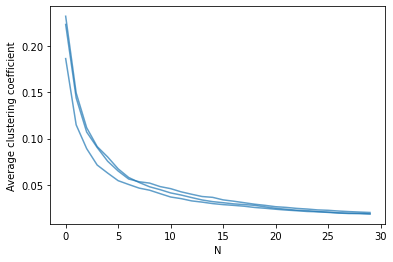

In [27]:
n_list = np.arange(100, 3100, 100)
m = 6
for _ in range(3):
    coeffs = generate_clustering_coef(n_list, m)
    plt.plot(coeffs, c='tab:blue', alpha=0.7)
plt.xlabel('N')
plt.ylabel('Average clustering coefficient')
plt.show()

### Task 6. Degree dynamics in Barabasi-Albert model (2 points)

Measure the degree dynamics in Barabasi-Albert model of one of the initial nodes and of the nodes added to the network at intermediate time moments (steps of the algorithm).

Write a function `generate_degree_dynamics` that takes np.array with considered nodes, generates Barabasi-Albert graph ($n=3000$, $m=6$) and returns a np.array of the shape `(29, len(nodes))` — degrees of these nodes at time moments 100, 200, 300, ..., 2900. If the node does not exist yet, pass `np.nan` value.

*Hint: use the `barabasi_albert_graph` function as a template*

In [22]:
def generate_degree_dynamics(cons_nodes):
  #G= barabasi_albert_graph(3000, 6 )
  m=6
  n= 3000
  i = 0
  con_len = len(cons_nodes)
  degree_dynamics = np.full((29,con_len), np.nan)
  G = nx.star_graph(m)
  for node in range(1+m, n):
    G = attach(node, G, m)
    if (node%100 == 0):
      j = 0
      for n in cons_nodes:
        if (node>=n):
          degree_dynamics[i,j]= G.degree(n)
          j = j+1
      i= i +1
  return degree_dynamics

    



    # YOUR CODE HERE
    #raise NotImplementedError()

In [23]:
degree_dynamics = generate_degree_dynamics([0, 100, 700, 2000])
assert degree_dynamics.shape == (29, 4)
assert np.all(np.isnan(degree_dynamics[0]) == [False, False,  True,  True])
assert np.all(np.isnan(degree_dynamics[9]) == [False, False,  False,  True])
assert degree_dynamics[0, 0] < degree_dynamics[-1, 0]
assert degree_dynamics[0, 1] < degree_dynamics[-1, 1]
assert degree_dynamics[-1, 0] > degree_dynamics[-1, 3]

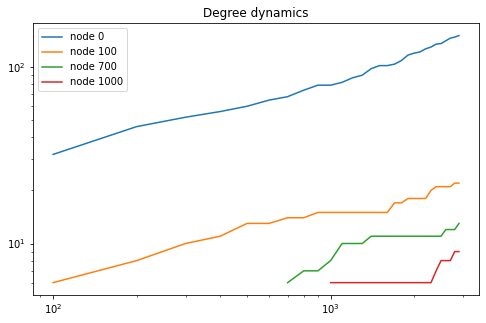

In [24]:
degree_dynamics = generate_degree_dynamics([0, 100, 700, 1000])
plt.figure(figsize=(8, 5))
time_space = np.tile(np.arange(100, 3000, 100), (4, 1)).T
plt.plot(time_space, degree_dynamics)
plt.legend(['node 0', 'node 100', 'node 700', 'node 1000'])
plt.title('Degree dynamics')
plt.xscale('log')
plt.yscale('log')
plt.show()